# Import modules

updated with CuDNNLSTM

In [1]:
import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
#from keras.layers.advanced_activations import LeakyReLU

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

import math
from sklearn.preprocessing import RobustScaler
from collections import deque

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


# Import the CSV file with technical data and sentiment analysis

In [2]:
data1 = pd.read_hdf('data2.h5', 'new_data')
#data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
data1['Y'] = data1.lrets.shift(-1)
data1.dropna(axis=0, inplace=True)
#data1.head()

# Train Test split for recurrent neural net

Bayesian Search tool Hyperas requires a function to import the data

http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

https://pythonprogramming.net/crypto-rnn-model-deep-learning-python-tensorflow-keras/?completed=/balancing-rnn-data-deep-learning-python-tensorflow-keras/

In [3]:
def data():
    def preprocess_df(data, shuffle=True):
        mapped_data = data.copy()
        SEQ_LEN = 60

        scaler = RobustScaler()
        data = scaler.fit_transform(data)

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

        for i in data:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target

            # if prev_days have 60 days of data
            if len(prev_days) == SEQ_LEN:
                # sequential_data = [prev_days_data, target variable]
                sequential_data.append([np.array(prev_days), i[-1]])  
        if shuffle == True:
            random.shuffle(sequential_data)  # shuffle for good measure.

        X = []
        y = []

        for seq, target in sequential_data:  # going over our new sequential data
            X.append(seq)  # X is the sequences
            y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

        return np.array(X), y 

    data1 = pd.read_hdf('data2.h5', 'new_data')
    #data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
    data1['Y'] = data1.lrets.shift(-1)
    data1.dropna(axis=0, inplace=True)
    times = sorted(data1.index.values)
    last_5pct = sorted(data1.index.values)[-int(0.05*len(times))]

    validation_main_df = data1[(data1.index >= last_5pct)]
    main_df = data1[(data1.index < last_5pct)]

    X_train, y_train = preprocess_df(main_df)
    X_val, y_val = preprocess_df(validation_main_df, shuffle=False)
    return X_train, y_train, X_val, y_val

In [4]:
X_train, y_train, X_val, y_val = data()

# Build up GRU model

- Using Bayesian search to search for the best model architecture

- Batchnorm and dropout for regularization

- https://www.quora.com/What-is-the-difference-between-dropout-and-batch-normalization

In [5]:
def create_model(X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(CuDNNLSTM({{choice([256, 512, 1024])}}, input_shape=(X_train.shape[1:]), return_sequences=True))
    model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.
    
    if {{choice(['two', 'three'])}} == 'three':
        model.add(CuDNNLSTM({{choice([128, 256, 512])}}, return_sequences=True))
        model.add(BatchNormalization())
        model.add(Dropout({{uniform(0, 1)}}))

    model.add(CuDNNLSTM({{choice([64, 128, 256])}}, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
        
    model.add(Dense({{choice([16, 32, 64])}}, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
    
    #if {{choice(['leakyrelu', 'tanh'])}} == 'tanh':
    #    model.add(Dense(1, activation='tanh'))
    #else:
    #    model.add(Dense(1, activation='linear'))
    #    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(loss='mse',optimizer={{choice(['adam', 'sgd'])}}, metrics=['accuracy'])
    
    result = model.fit(X_train, y_train,
          batch_size={{choice([8, 64])}},
          epochs=3,
          verbose=2,
          validation_split=0.1)
    
    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_acc']) 
    
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [6]:
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=Trials(),
                                      notebook_name='6. Bayesian search')
X_train, Y_train, X_test, Y_test = data()
best_model.evaluate(X_test, Y_test)

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import random
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, LeakyReLU
except:
    pass

try:
    from tensorflow.keras.callbacks import TensorBoard
except:
    pass

try:
    from tensorflow.keras.callbacks import ModelCheckpoint
except:
    pass

try:
    from tensorflow.keras.callbacks import Callback
except:
    pass

try:
    import tensorflow.keras.backend as K
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    import math
except:
    pass

try:
    from sklearn.preprocessing import Robus

[2.9243237142977505, 0.0]

In [7]:
best_run

{'CuDNNLSTM': 1,
 'CuDNNLSTM_1': 1,
 'CuDNNLSTM_2': 1,
 'CuDNNLSTM_3': 2,
 'Dense': 2,
 'Dropout': 0.3207527760045966,
 'Dropout_1': 0.7342146978592597,
 'Dropout_2': 0.692539034315719,
 'Dropout_3': 0,
 'batch_size': 1,
 'optimizer': 0}

In [8]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 60, 512)           1071104   
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 512)           2048      
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 60, 256)           788480    
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 256)           1024      
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

In [9]:
trainScore = best_model.evaluate(X_train, y_train, verbose=0)
print('Train RMSE: %2f' % math.sqrt(trainScore[0]))

testScore = best_model.evaluate(X_val, y_val, verbose=0)
print('Test RMSE: %2f'% math.sqrt(testScore[0]))

Train RMSE: 1.214087
Test RMSE: 1.710065


In [10]:
p = best_model.predict(X_val)

In [11]:
p

array([[-0.27812603],
       [-0.28023812],
       [-0.28052413],
       [-0.27906224],
       [-0.28114653],
       [-0.28050864],
       [-0.27908546],
       [-0.27816993],
       [-0.27746588],
       [ 0.16428892],
       [-0.2786022 ],
       [-0.2839166 ],
       [ 0.1649587 ],
       [ 0.16394548],
       [ 0.1646165 ],
       [ 0.16082357],
       [ 0.16245025],
       [-0.28478152],
       [ 0.1627602 ],
       [-0.2839347 ],
       [-0.28338978],
       [-0.28383735],
       [-0.28554732],
       [-0.29066938],
       [-0.2927405 ],
       [-0.29225358],
       [-0.28938547],
       [-0.28903428],
       [-0.28856257],
       [-0.28989416],
       [-0.29222807],
       [-0.29172513],
       [-0.29278934],
       [-0.29206505],
       [-0.29018337],
       [-0.28832966],
       [-0.28687775],
       [-0.2862999 ],
       [-0.28806865],
       [-0.28666744],
       [-0.28619078],
       [ 0.16618332],
       [ 0.16557322],
       [ 0.1649934 ],
       [ 0.16414694],
       [ 0

If the chosen model fits worse than a horizontal line, then R2 is negative.

# Plotting Predicted value vs True value

In [12]:
data1 = pd.read_hdf('data2.h5', 'new_data')
#data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
data1['Y'] = data1.lrets.shift(-1)
data1.dropna(axis=0, inplace=True)
times = sorted(data1.index.values)
last_5pct = sorted(data1.index.values)[-int(0.05*len(times))]
validation_main_df = data1[(data1.index >= last_5pct)]
prescaler = RobustScaler()
prescaler = prescaler.fit(validation_main_df)
padding = np.zeros((184, 9))
pred_result = pd.DataFrame(data=padding)
pred_result['9'] = p
pred = prescaler.inverse_transform(pred_result)

val_result = pd.DataFrame(data=padding)
val_result['9'] = y_val
val = prescaler.inverse_transform(val_result)

In [13]:
pred = pred[:, -1]
val = val[:, -1]

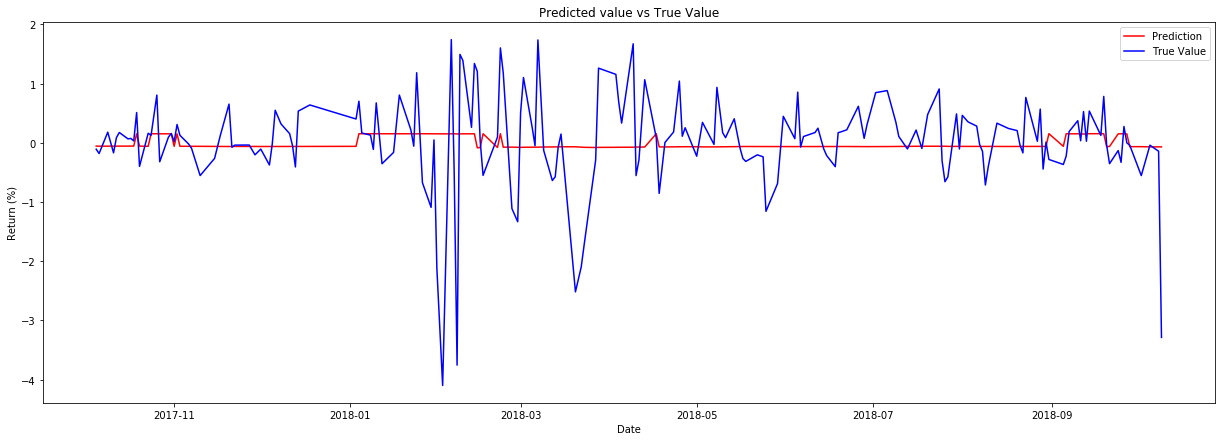

In [14]:
plt.figure(figsize=(21,7))
plt.plot(data1.index[-len(pred):], np.expm1(pred)*100, color='red', label='Prediction')
plt.plot(data1.index[-len(val):], np.expm1(val)*100, color='blue', label='True Value')
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.title('Predicted value vs True Value')
plt.legend(loc='best')
plt.show()

# The residual plot is not normal

((array([-2.67289247, -2.36046913, -2.18213076, -2.05428693, -1.95319937,
         -1.86884759, -1.7960154 , -1.73162634, -1.67370719, -1.62091343,
         -1.57228594, -1.52711548, -1.48486215, -1.44510502, -1.40750925,
         -1.37180394, -1.33776662, -1.30521228, -1.27398532, -1.24395353,
         -1.21500362, -1.18703768, -1.15997053, -1.13372755, -1.10824298,
         -1.08345855, -1.05932238, -1.03578805, -1.01281386, -0.99036218,
         -0.96839893, -0.94689317, -0.92581667, -0.90514361, -0.88485034,
         -0.86491508, -0.84531776, -0.82603984, -0.80706413, -0.78837467,
         -0.76995661, -0.75179612, -0.73388025, -0.71619691, -0.69873475,
         -0.68148309, -0.66443192, -0.64757178, -0.63089375, -0.61438939,
         -0.59805072, -0.58187017, -0.56584054, -0.54995501, -0.53420707,
         -0.51859052, -0.50309943, -0.48772815, -0.47247125, -0.45732355,
         -0.44228007, -0.42733602, -0.41248681, -0.39772801, -0.38305534,
         -0.36846467, -0.35395204, -0.

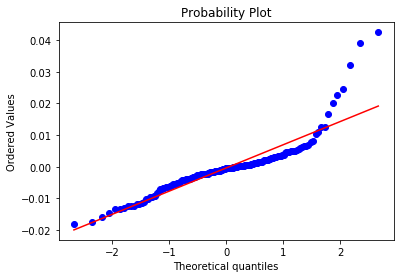

In [15]:
import scipy.stats as stats
residual = np.expm1(pred) - np.expm1(val)
stats.probplot(residual, dist="norm", plot=plt)

In [195]:
# Updates to be continued